<a href="https://colab.research.google.com/github/prateekbeh/algo_ds/blob/master/GRACE_Mascon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset as dt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.dates as mdt
import matplotlib.gridspec as gridspec
from matplotlib.colorbar import Colorbar
from datetime import datetime
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.animation as anim
from shapely.geometry import Point , shape , Polygon
from dataclasses import dataclass, fields
import matplotlib.pyplot as pl
import hvplot.xarray
import fiona
import shapefile
import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask
import netCDF4 as nc
import math
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
from datetime import date
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon, MultiPolygon, Point
from matplotlib.colors import TwoSlopeNorm
import cftime

In [ ]:
gr_dt = xr.open_dataset("/Users/prateekb/Downloads/DL_doc/gsfc.glb_.200204_202403_rl06v2.0_obp-ice6gd_halfdegree.nc")
gr_dt.lwe_thickness.hvplot.image(y='lat', x='lon', cmap='bwr_r',).opts(clim=(-80,80))


:DynamicMap   [time]
   :Image   [lon,lat]   (Liquid_Water_Equivalent_Thickness)

In [ ]:
gr_dt

<xarray.Dataset> Size: 481MB
Dimensions:        (lon: 720, lat: 360, time: 231, bounds: 2)
Coordinates:
  * lon            (lon) float64 6kB 0.25 0.75 1.25 1.75 ... 358.8 359.2 359.8
  * lat            (lat) float64 3kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2kB 2002-04-18 ... 2024-03-17
Dimensions without coordinates: bounds
Data variables:
    land_mask      (lat, lon) float64 2MB ...
    lwe_thickness  (time, lat, lon) float64 479MB ...
    lon_bounds     (lon, bounds) float64 12kB ...
    lat_bounds     (lat, bounds) float64 6kB ...
    time_bounds    (time, bounds) datetime64[ns] 4kB ...
Attributes: (12/25)
    title:                      NASA GSFC GRACE and GRACE-FO MASCON RL06 v1.0
    summary:                    Monthly gravity solutions from GRACE and GRAC...
    platform:                   GRACE and GRACE-FO
    creator_name:               Bryant Loomis
    creator_email:              bryant.d.loomis@nasa.gov
    creator_url:                https://earth.gsfc.nasa.gov/geo/data/grace-ma...
    ...                         ...
    GIA_removed:                ICE6G-D; Peltier, W. R., D. F. Argus, and R. ...
    geocenter_correction:       JPL TN-13
    C_20_substitution:          TN-14; Loomis et al., 2020, Geophys. Res. Let...
    C_30_substitution:          TN-14; Loomis et al., 2020, Geophys. Res. Let...
    journal_reference:          Loomis et al. 2019, J. Geod., https://doi.org...
    date_created:               date_stamp

In [ ]:
lat = gr_dt['lat']    # Latitude grid (1D array)
lon = gr_dt['lon']    # Longitude grid (1D array)
lwe_thickness = gr_dt['lwe_thickness']  # Load lwe_thickness (e.g., (lat, lon,time))

In [ ]:
start_date = date(2002, 1, 1)
ref = np.datetime64(start_date)
T = []
for i in range(0,len(lwe_thickness.time.values)):

    dt = lwe_thickness.time[i].values
    T.append((dt.astype('datetime64[D]') - ref).astype('timedelta64[D]').astype(int));


In [ ]:
def fit(grace_dt,coords,T):

    t = len(T)

    sum_for_grid = 0;

    tws = [0 for x in range(0,t)];

    for i in range(0,t):
        sum_for_area = 0;
        for j in range(0,len(coords)):
            sum_for_area += lwe_thickness.sel(lat= coords[j][0], lon=coords[j][1] ).values[i]
        tws[i] = sum_for_area / len(coords);


    T1 = 365;
    T2 = T1/2;
    u = 6; # no of parameters
    pi = 3.14;
    A = [[0 for x in range(u)] for y in range(t)]

    for i in range(0, t):
        A[i][0] = 1;
        A[i][1] = T[i];
        A[i][2] = math.cos(2*pi*T[i]/T1);
        A[i][3] = math.sin(2*pi*T[i]/T1);
        A[i][4] = math.cos(2*pi*T[i]/T2);
        A[i][5] = math.sin(2*pi*T[i]/T2);


    A = np.array(A)
    A_transpose = A.transpose()
    ATA_inv = np.linalg.inv(np.dot(A_transpose , A) )
    ATTWS = np.dot(A_transpose , tws )
    X_cap = np.dot(ATA_inv, ATTWS)
    print(X_cap)
    L_cap = np.dot(A, X_cap)
    return L_cap , tws

In [ ]:
def fit1(dt,T):
    t = len(T)

    T1 = 365;
    T2 = T1/2;
    u = 6; # no of parameters
    pi = 3.14;
    A = [[0 for x in range(u)] for y in range(t)]

    for i in range(0, t):
        A[i][0] = 1;
        A[i][1] = T[i];
        A[i][2] = math.cos(2*pi*T[i]/T1);
        A[i][3] = math.sin(2*pi*T[i]/T1);
        A[i][4] = math.cos(2*pi*T[i]/T2);
        A[i][5] = math.sin(2*pi*T[i]/T2);



    A = np.array(A)
    A_transpose = A.transpose()
    ATA_inv = np.linalg.inv(np.dot(A_transpose , A) )
    ATTWS = np.dot(A_transpose , dt )
    X_cap = np.dot(ATA_inv, ATTWS)
    L_cap = np.dot(A, X_cap)
    return X_cap[1] , X_cap[2], X_cap[3];

In [ ]:
def avg_drought(ds , coords , t):


    avg_spei = [0 for x in range(0,t)];
    n = len(coords);
    for i in range(0,t):
        sum_for_area = 0;
        for j in range(0,n):
            sum_for_area += ds.sel(lat= coords[j][0], lon=coords[j][1] ).spei.values[i]
        avg_spei[i] = sum_for_area / n;
        print( i , avg_spei[i]);

    return avg_spei;

In [ ]:
def create_grid_centers(bounds, grid_size=0.5):
    minx, miny, maxx, maxy = bounds
    x_coords = np.arange(minx, maxx, grid_size)
    y_coords = np.arange(miny, maxy, grid_size)

    centers = []
    for x in x_coords:
        for y in y_coords:
            # Calculate the center of each grid cell
            center_x = x + grid_size / 2
            center_y = y + grid_size / 2
            centers.append(Point(center_x, center_y))

    return centers

In [ ]:
def plot(df1 , msg):
    try:
        pio.renderers.default = 'iframe'
        print("Plotly is installed and ready.")
    except Exception as e:
        print("Error setting up Plotly:", e)

    # Create the figure
    fig = go.Figure()

    # Add LWE data (left y-axis)
    fig.add_trace(go.Scatter(
        x=lwe_df['Date'],
        y=lwe_df['Value'],
        mode='markers+lines',
        marker=dict(size=8, color='blue'),
        line=dict(color='blue'),
        hoverinfo='text',
        hovertext=[f"Date: {date}<br>LWE: {value}" for date, value in zip(lwe_df['Date'], lwe_df['Value'])],
        name='LWE',
    ))

    fig.update_layout(
        title=msg,
        xaxis_title="Date",
        yaxis_title="LWS (in cm)",
        hovermode="x unified",
        template="plotly_white"  # Optional: clean background template
    )

    # Step 5: Show the interactive plot
    fig.show()

In [ ]:
def plott(df1 , df2 , msg):

    try:
        pio.renderers.default = 'iframe'
        print("Plotly is installed and ready.")
    except Exception as e:
        print("Error setting up Plotly:", e)


    fig = go.Figure()


    fig.add_trace(go.Scatter(
        x=df1['Date'],
        y=df1['Value'],
        mode='markers+lines',  # Show both markers and lines
        marker=dict(size=8, color='blue'),
        line=dict(color='blue'),
        hoverinfo='text',
        hovertext=[f"Date: {date}<br>Value: {value}" for date, value in zip(df1['Date'], df1['Value'])],
        name='Observed Values'
    ))

    fig.add_trace(go.Scatter(
        x=df2['Date'],
        y=df2['Value'],
        mode='markers+lines',  # Show both markers and lines
        marker=dict(size=8, color='red'),
        line=dict(color='red'),
        hoverinfo='text',
        hovertext=[f"Date: {date}<br>Value: {value}" for date, value in zip(df2['Date'], df2['Value'])],
        name='Estimated Values'
    ))


    fig.update_layout(
        title=msg,
        xaxis_title="Date",
        yaxis_title="LWS (in cm)",
        hovermode="x unified",
        template="plotly_white"  # Optional: clean background template
    )

    # Step 5: Show the interactive plot
    fig.show()

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio

def plot_lwe_spei(lwe_df, spei_df, msg):
    """
    Plot LWE, TWS (estimated), and SPEI data with different timestamps on dual y-axes.
    """
    try:
        pio.renderers.default = 'iframe'
        print("Plotly is installed and ready.")
    except Exception as e:
        print("Error setting up Plotly:", e)

    # Create the figure
    fig = go.Figure()

    # Add LWE data (left y-axis)
    fig.add_trace(go.Scatter(
        x=lwe_df['Date'],
        y=lwe_df['Value'],
        mode='markers+lines',
        marker=dict(size=8, color='blue'),
        line=dict(color='blue'),
        hoverinfo='text',
        hovertext=[f"Date: {date}<br>LWE: {value}" for date, value in zip(lwe_df['Date'], lwe_df['Value'])],
        name='LWE',
    ))

    # Add SPEI data (right y-axis)
    fig.add_trace(go.Scatter(
        x=spei_df['Date'],
        y=spei_df['SPEI'],
        mode='markers+lines',
        marker=dict(size=8, color='green'),
        line=dict(color='green'),
        hoverinfo='text',
        hovertext=[f"Date: {date}<br>SPEI: {value}" for date, value in zip(spei_df['Date'], spei_df['SPEI'])],
        name='SPEI',
        yaxis='y2',  # Assign to secondary y-axis
    ))

    # Update the layout for dual y-axes
    fig.update_layout(
        title=msg,
        xaxis=dict(title="Date"),
        yaxis=dict(title="LWE / TWS (in cm)", showgrid=True),  # Combined y-axis title
        yaxis2=dict(
            title="SPEI",
            overlaying='y',  # Overlay y2 on y1
            side='right'  # Place the secondary y-axis on the right side
        ),
        hovermode="x unified",
        template="plotly_white"
    )

    # Show the plot
    fig.show()



In [ ]:
def create_df1(arg1, tim):
    df1 = pd.DataFrame({
        'Date': tim,
        'Value': arg1
    })
    return df1

In [ ]:
def create_df(o_tws , e_tws , tim):
    df1 = pd.DataFrame({
        'Date': tim,
        'Value': o_tws
    })

    df2 = pd.DataFrame({
        'Date': tim,
        'Value': e_tws
    })
    return df1 , df2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import Normalize
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_trend_map1(lat_min, lat_max, lon_min, lon_max, lat_array, lon_array, trend_array, aquifer_boundary,flag):
    """
    Generates a trend map with 0.5x0.5 degree rectangular grids, stores the coordinates,
    and plots the aquifer boundary with trend values.
    """
    if flag == 1:
        vmin, vmax = trend_array.min(), trend_array.max()
    else:
        vmin , vmax = -3 , 3

    fig, ax = plt.subplots(
        figsize=(6, 8),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )

    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle='--', edgecolor='gray')

    aquifer_boundary.plot(ax=ax, edgecolor='black', linewidth=1.5, facecolor='none')

    cmap = plt.get_cmap('RdBu')
    norm = Normalize(vmin=vmin, vmax=vmax)

    grid_data = []

    for lat, lon, trend in zip(lat_array, lon_array, trend_array):
        color = cmap(norm(trend))

        center_lat = lat
        center_lon = lon

        grid_data.append((center_lat, center_lon, trend))

        rect = plt.Rectangle(
            (lon - 0.25, lat - 0.25),  # Bottom-left corner
            0.5, 0.5,  # Width and height of each cell
            edgecolor='black', facecolor=color, alpha=0.7,
            transform=ccrs.PlateCarree()
        )
        ax.add_patch(rect)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
    cbar.set_label('', fontsize=10)
    cbar.ax.tick_params(labelsize=8)

    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    state_labels = {'CO': (-105.5, 39), 'KS': (-98, 38), 'OK': (-98, 35),
                    'TX': (-102, 33), 'NM': (-104, 34), 'NE': (-99, 41),
                    'SD': (-100, 44), 'WY': (-107, 43)}
    for state, (x, y) in state_labels.items():
        ax.text(x, y, state, transform=ccrs.PlateCarree(), fontsize=10, ha='center')

    ax.plot([-106, -96], [38, 38], linestyle='--', color='black', transform=ccrs.PlateCarree())

    ax.text(-97, 39.5, 'NORTH', fontsize=12, weight='bold', ha='center', transform=ccrs.PlateCarree())
    ax.text(-97, 36.5, 'SOUTH', fontsize=12, weight='bold', ha='center', transform=ccrs.PlateCarree())

    plt.show()

    grid_df = pd.DataFrame(grid_data, columns=['Latitude', 'Longitude', ''])
    return grid_df


In [ ]:
def extract_spei_for_coords(ds, coords_df):
    """Extract SPEI values for given lat/lon coordinates from an Xarray dataset."""
    results = []

    for _, row in coords_df.iterrows():
        lon, lat = row['lon'], row['lat']

        # Extract the nearest SPEI value for the given coordinate
        spei_value = ds['spei'].sel(lat=lat, lon=lon).values
        results.append({'lat': lat, 'lon': lon, 'spei': spei_value})
        print(results)
    # Convert results to a DataFrame
    return pd.DataFrame(results)


In [ ]:
# to get the coords for High Plains Aquifer.

shapefile_path = '/Users/prateekb/Desktop/hpa_shapefile.shp'
gdf = gpd.read_file(shapefile_path)


# Get the bounds of the shapefile (minx, miny, maxx, maxy)
bounds = gdf.total_bounds
#print(bounds)


grid_centers = create_grid_centers(bounds, grid_size=0.5)
grid_centers_gdf = gpd.GeoDataFrame(geometry=grid_centers, crs=gdf.crs)

intersecting_centers = grid_centers_gdf[grid_centers_gdf.intersects(gdf.union_all())]

coords = [(point.x, point.y) for point in intersecting_centers.geometry]

In [ ]:
coords_aquifer = [];
for i in range(0,len(coords)):
    coords_aquifer.append([ round((coords[i][0] + 360 + 0.25) * 2) / 2 - 0.25 , round((coords[i][1] + 0.25) * 2) / 2 - 0.25 ])

In [ ]:
aquifer_lat = [row[1] for row in coords_aquifer]
aquifer_lon = [row[0] for row in coords_aquifer]
aquifer_coords = [list(row) for row in zip(aquifer_lat, aquifer_lon)]

In [ ]:
[e_tws_w , o_tws_w] = fit(lwe_thickness,aquifer_coords, T)

[ 2.10798204e+00 -1.33534612e-03 -1.01566286e+00  3.73441313e+00
  1.04309597e+00 -9.09700987e-01]


In [ ]:
[df1 , df2] = create_df(o_tws_w,e_tws_w,pd.to_datetime(gr_dt.lwe_thickness.time.values).date )
msg = "Plot of estimated vs observed LWS(in cm) of data vs time for all of the High plain aquifer"
plott(df1 , df2, msg)

Plotly is installed and ready.


In [ ]:
north_coords = [row for row in aquifer_coords if row[0] >= 38.25]

In [ ]:
[e_tws_n , o_tws_n]  = fit(lwe_thickness,north_coords,T)

[-1.21536404e+00  9.55833031e-04 -1.82801283e+00  4.00611486e+00
  1.08413459e+00 -1.15114738e+00]


In [ ]:
[df1 , df2] = create_df(o_tws_n,e_tws_n,pd.to_datetime(gr_dt.lwe_thickness.time.values).date )
msg = "Plot of estimated vs observed LWS(in cm) of data vs time for all of the High plain aquifer(North)"

plott(df1 , df2,msg)

Plotly is installed and ready.


In [ ]:
south_coords = [row for row in aquifer_coords if row[0] <= 38.25]

In [ ]:
[e_tws_s , o_tws_s] = fit(lwe_thickness,south_coords,T)

[ 7.11246605e+00 -4.78275965e-03  2.15415308e-01  3.33214731e+00
  9.89284830e-01 -5.49766253e-01]


In [ ]:
## southern region plot

[df1 , df2] = create_df(o_tws_s,e_tws_s,pd.to_datetime(gr_dt.lwe_thickness.time.values).date )
msg = "Plot of estimated vs observed LWS(in cm) of data vs time for all of the High plain aquifer(South)"
plott(df1 , df2, msg)

Plotly is installed and ready.


In [ ]:
## Code to generate the trend, amplitude map

In [ ]:
lat_min = 32;
lat_max = 44;
lon_min = 254;
lon_max = 264;

In [ ]:
trend_hpa = [];
amp = [];
for i in range(0,len(aquifer_coords)):
    trend, fi , se = fit1(lwe_thickness.sel(lat = aquifer_coords[i][0] , lon = aquifer_coords[i][1]).values , T)
    trend_hpa.append(trend)
    amp.append(math.sqrt(fi * fi + se * se));

hpa_lat = [row[0] for row in aquifer_coords]
hpa_lon = [row[1] for row in aquifer_coords]


In [ ]:
trend_hpa2 = np.array(trend_hpa) * 365
amp2 = np.array(amp)

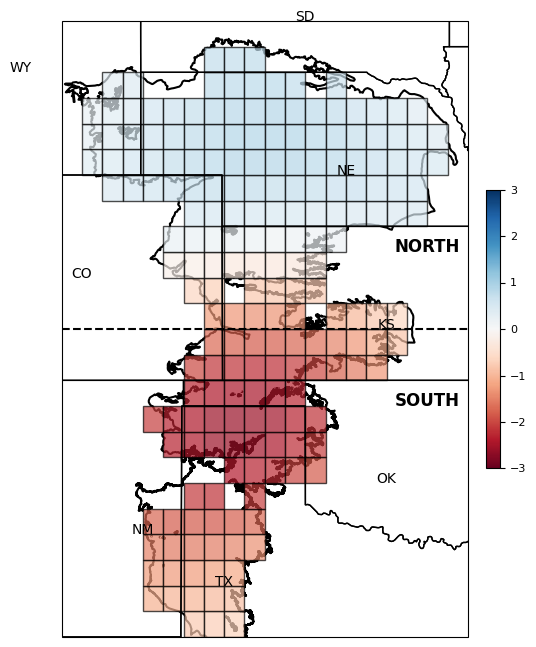

In [ ]:
grid_df = plot_trend_map1(lat_min, lat_max , lon_min , lon_max , hpa_lat , hpa_lon , trend_hpa2 , gdf , 0)

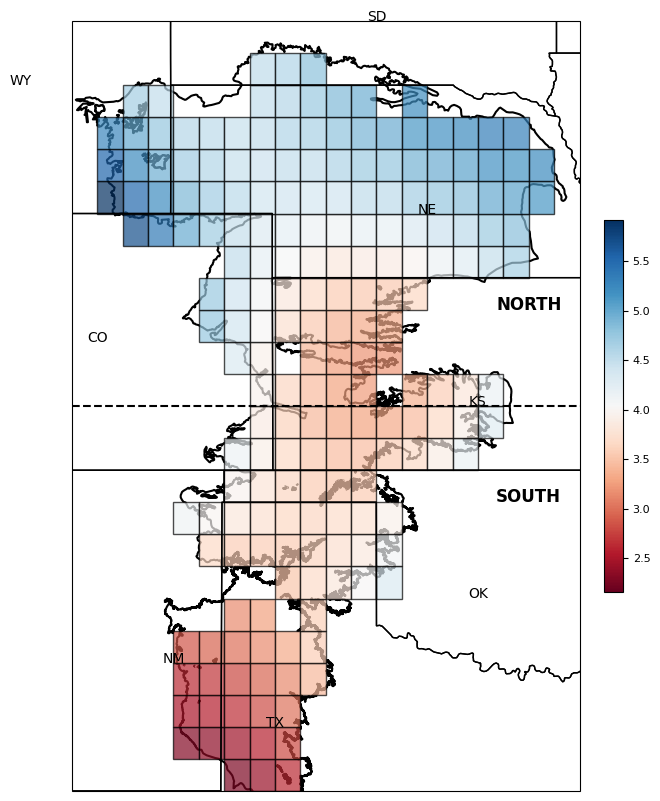

In [ ]:
grid_df = plot_trend_map1(lat_min, lat_max , lon_min , lon_max , hpa_lat , hpa_lon , amp2 , gdf , 1)

In [ ]:
def get_avg_spei(spei_file , lwe_timestamp):

    drought_indices = xr.open_dataset(spei_file)
    ds = drought_indices.assign_coords(lon=((drought_indices['lon'] + 180) % 360))




    spei_monthly_time = pd.to_datetime(ds.time.values).to_period('M')
    lwe_monthly_time = pd.to_datetime(lwe_timestamp).to_period('M')


    common_times = np.intersect1d(spei_monthly_time, lwe_monthly_time)


    common_times_dt = [pd.Timestamp(ct.start_time) for ct in common_times]

    filtered_ds = ds.sel(time=common_times_dt, method='nearest')
    filtered_ds = filtered_ds.load()  # Load data for faster access

    coords_df = pd.DataFrame(aquifer_coords, columns=['lat', 'lon']);

    t = len(filtered_ds.time.values);
    avg_spei = [0 for x in range(0,t)];

    n = len(aquifer_coords);
    for i in range(0,t):
        sum_for_area = 0;
        for j in range(0,n):
            sum_for_area += filtered_ds.sel(lat= aquifer_coords[j][0], lon=aquifer_coords[j][1]).spei.values[i];
        avg_spei[i] = sum_for_area / n;



    spei_data = {'Date': pd.to_datetime(filtered_ds.time.values).date,
                 'SPEI': avg_spei}
    return spei_data


In [ ]:
def convert_cftime_to_datetime64(ds):
    """
    Convert cftime time values in an xarray Dataset to datetime64[ns].

    Parameters:
    - ds: xarray.Dataset with 'time' coordinate in cftime format.

    Returns:
    - ds: xarray.Dataset with 'time' coordinate converted to datetime64[ns], if within bounds.
    """
    if isinstance(ds['time'].values[0], cftime.datetime):
        # Convert cftime to datetime64, handling dates outside of datetime64 range
        datetime64_times = []
        for t in ds['time'].values:
            try:
                # Convert to datetime64 if within range
                datetime64_times.append(np.datetime64(pd.Timestamp(t.isoformat())))
            except ValueError:
                # If out of bounds, fallback to NaT or another suitable representation
                datetime64_times.append(np.datetime64('NaT'))

        # Assign converted time values back to the Dataset
        ds = ds.assign_coords(time=("time", datetime64_times))
    else:
        print("Time values are already in datetime64 format.")

    return ds

In [ ]:
def get_data_old(ds):

    units = ds['time'].attrs['units']
    calendar = ds['time'].attrs.get('calendar', 'standard')

    import cftime
    time_values = cftime.num2date(ds['time'].values, units=units, calendar=calendar)
    ds['time'] = ('time', time_values)
    ds = convert_cftime_to_datetime64(ds)
    return ds

In [ ]:
def get_data(ds,lwe_timestamp ,arg):

    ds = ds.assign_coords(lon=((ds['lon'] + 180) % 360))

    arg_monthly_time = pd.to_datetime(ds.time.values).to_period('M')
    lwe_monthly_time = pd.to_datetime(lwe_timestamp).to_period('M')

    # Find common year-month timestamps
    common_times = np.intersect1d(arg_monthly_time, lwe_monthly_time)

    # Convert common_times back to datetime format to match xarray's time indexing
    common_times_dt = [pd.Timestamp(ct.start_time) for ct in common_times]


    filtered_ds = ds.sel(time=common_times_dt, method='nearest')
    filtered_ds = filtered_ds.load()  # Load data for faster access

    coords_df = pd.DataFrame(aquifer_coords, columns=['lat', 'lon']);

    t = len(filtered_ds.time.values);
    avg_arg = [0 for x in range(0,t)];

    n = len(aquifer_coords);
    for i in range(0,t):
        sum_for_area = 0;
        for j in range(0,n):
            sum_for_area += filtered_ds.sel(lat= aquifer_coords[j][0], lon=aquifer_coords[j][1])[arg].values[i];
        avg_arg[i] = sum_for_area / n;



    arg_data = {'Date': pd.to_datetime(filtered_ds.time.values).date,
                 'ARG': avg_arg}
    return arg_data


In [ ]:


# for 1 month averaging
spei_df_1 = get_avg_spei("/Users/prateekb/Desktop/spei01.nc" , lwe_thickness.time.values);


# for 3 month averaging
spei_df_3 = get_avg_spei("/Users/prateekb/Desktop/spei03.nc" , lwe_thickness.time.values);

# for 5 month averaging
spei_df_5 = get_avg_spei("/Users/prateekb/Desktop/spei05.nc" , lwe_thickness.time.values);


# for 10 month averaging
spei_df_10 = get_avg_spei("/Users/prateekb/Desktop/spei10.nc" , lwe_thickness.time.values);


lwe_data = {'Date': pd.to_datetime(gr_dt.lwe_thickness.time.values).date,
            'Value': o_tws_w}
lwe_df = pd.DataFrame(lwe_data)


#plot_lwe_spei(lwe_df, spei_df_1, "Comparison of LWE, and SPEI Data - (Avg 1 month)")
plot_lwe_spei(lwe_df, spei_df_3, "Comparison of LWE, and SPEI Data - (Avg 3 month)")
#plot_lwe_spei(lwe_df, spei_df_5, "Comparison of LWE, and SPEI Data - (Avg 5 month)")
#plot_lwe_spei(lwe_df, spei_df_10, "Comparison of LWE, and SPEI Data - (Avg 10 month)")

Plotly is installed and ready.


In [ ]:


tws_old = get_data_old(xr.open_dataset("/Users/prateekb/Desktop/thesis/tws.nc", decode_times=False));

sm_old = get_data_old(xr.open_dataset("/Users/prateekb/Desktop/thesis/soilmoist.nc", decode_times=False));
snow_water_old = get_data_old(xr.open_dataset("/Users/prateekb/Desktop/thesis/swe.nc", decode_times=False));

cp_old = get_data_old(xr.open_dataset("/Users/prateekb/Desktop/thesis/canopystor.nc", decode_times=False));

lls_old = get_data_old(xr.open_dataset("/Users/prateekb/Desktop/thesis/loclakestor.nc", decode_times=False));
gls_old = get_data_old(xr.open_dataset("/Users/prateekb/Desktop/thesis/glolakestor.nc", decode_times=False));

lwls_old = get_data_old(xr.open_dataset("/Users/prateekb/Desktop/thesis/locwetlandstor.nc", decode_times=False));
gwls_old = get_data_old(xr.open_dataset("/Users/prateekb/Desktop/thesis/glowetlandstor.nc", decode_times=False));

ris_old = get_data_old(xr.open_dataset("/Users/prateekb/Desktop/thesis/riverstor.nc", decode_times=False));
res_old = get_data_old(xr.open_dataset("/Users/prateekb/Desktop/thesis/reservoirstor.nc", decode_times=False));




tws = get_data(tws_old , lwe_thickness.time.values , "tws" );

sm = get_data(sm_old , lwe_thickness.time.values , "soilmoist" );
snow_water = get_data(snow_water_old, lwe_thickness.time.values , "swe");

cp = get_data(cp_old, lwe_thickness.time.values , "canopystor");

lls = get_data(lls_old , lwe_thickness.time.values , "loclakestor" );
gls = get_data(gls_old, lwe_thickness.time.values , "glolakestor");

lwls = get_data(lwls_old , lwe_thickness.time.values , "locwetlandstor" );
gwls = get_data(gwls_old, lwe_thickness.time.values , "glowetlandstor");

ris = get_data(ris_old , lwe_thickness.time.values , "riverstor" );
res = get_data(res_old, lwe_thickness.time.values , "reservoirstor");




/var/folders/my/fm_4jwz90fqcy51vn6sdpl2r0000gn/T/ipykernel_50912/2268312834.py:23: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

/var/folders/my/fm_4jwz90fqcy51vn6sdpl2r0000gn/T/ipykernel_50912/2268312834.py:23: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can

[-14.489717457935454, -20.264504742216797, -37.7252649394912, -37.51139512202601, -39.41408903100948, -38.97861344620159, -34.20545750311668, -32.221117389773596, -21.231250342179614, -2.895081643948774, 1.7234130006077202, -4.2981897507711215, -29.933080581842553, -32.878232119863135, -34.41512896256097, -35.00516167845828, -30.429414715864553, -26.303475608784094, -20.842141646890607, -11.719609371913844, -8.695731590695605, -15.808922162796872, -20.818583251286004, -29.68679988386091, -34.64639487765892, -36.35857138709317, -40.37638246948534, -41.771317748884144, -40.82140475270986, -36.909699190653846, -27.235358390944437, -7.3341945739241305, -0.5323990430984705, -0.804843921703056, -13.665270894443118, -23.804171428695266, -33.11668281452638, -36.00475763275961, -37.64214632652349, -39.59886689253669, -38.95542465933489, -37.09911755556118, -24.35960379642167, -16.24706774633055, -8.852894957559437, -5.934001051251417, -20.86365247256855, -33.72114965670032, -38.061948047748004,

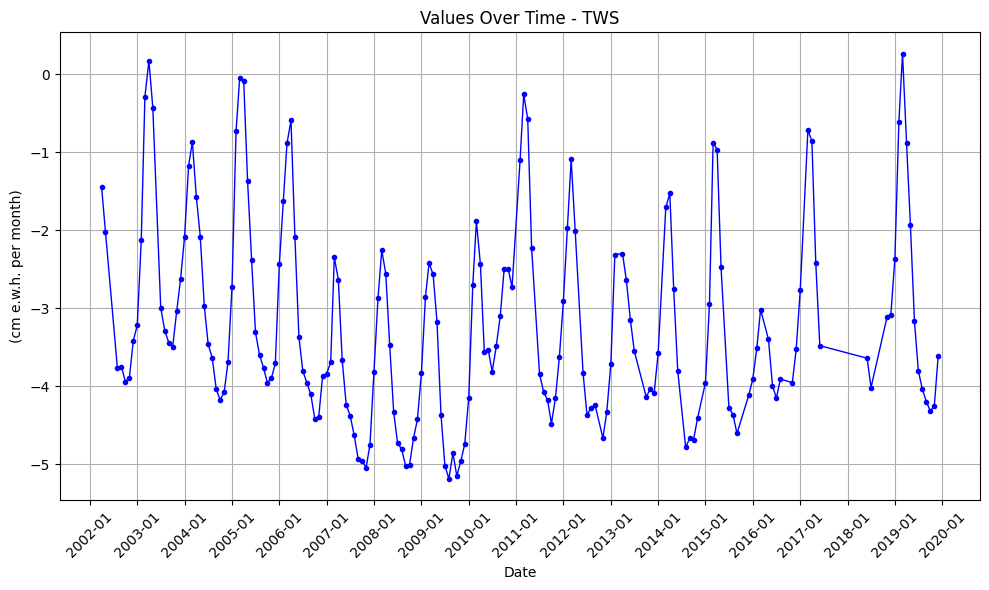

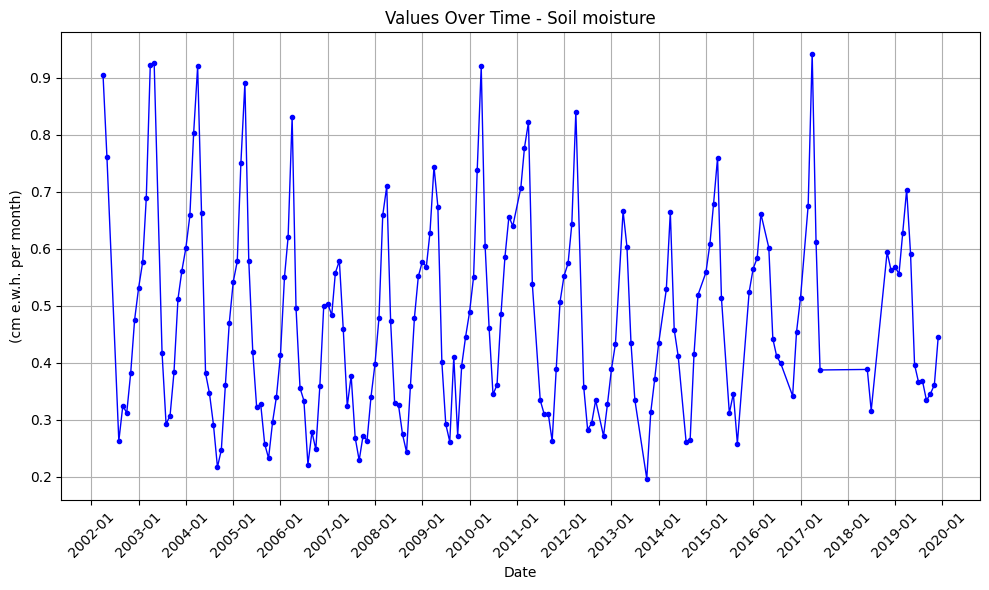

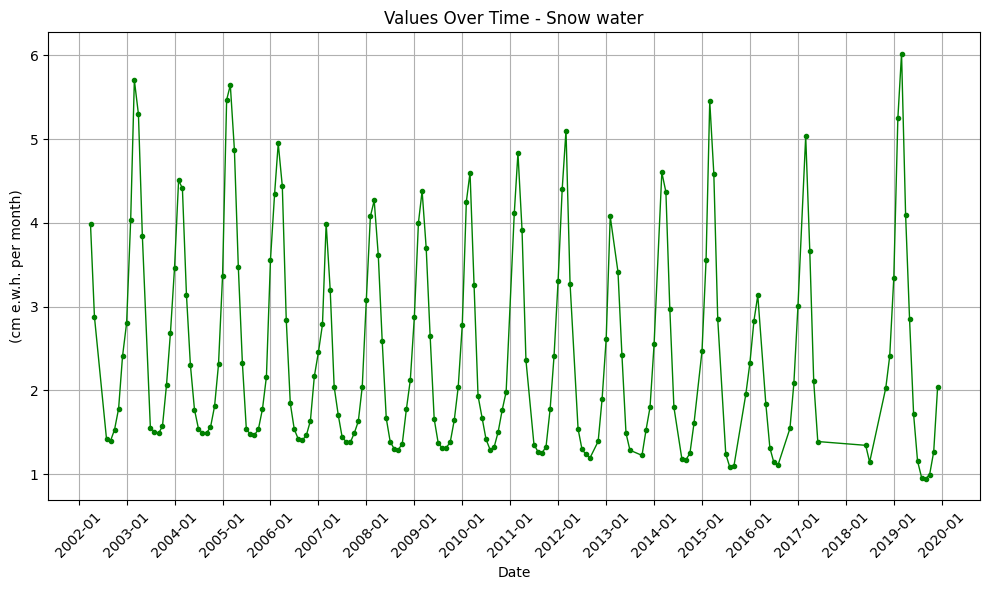

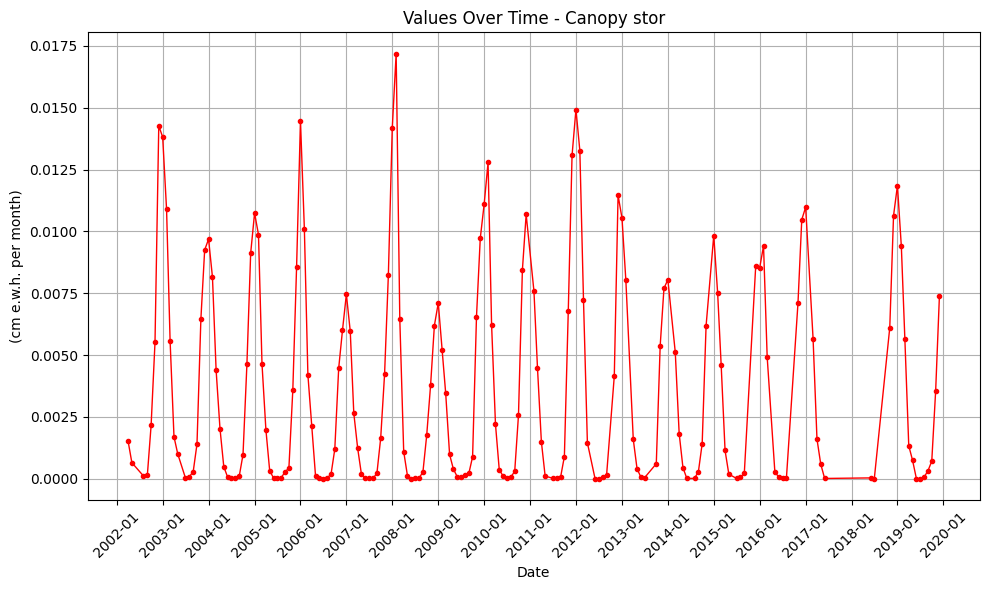

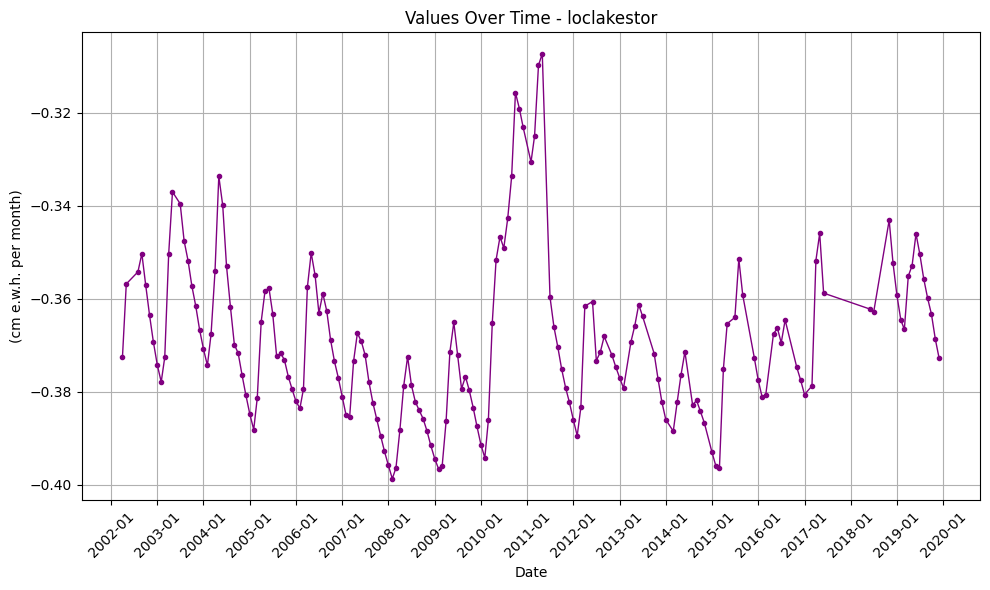

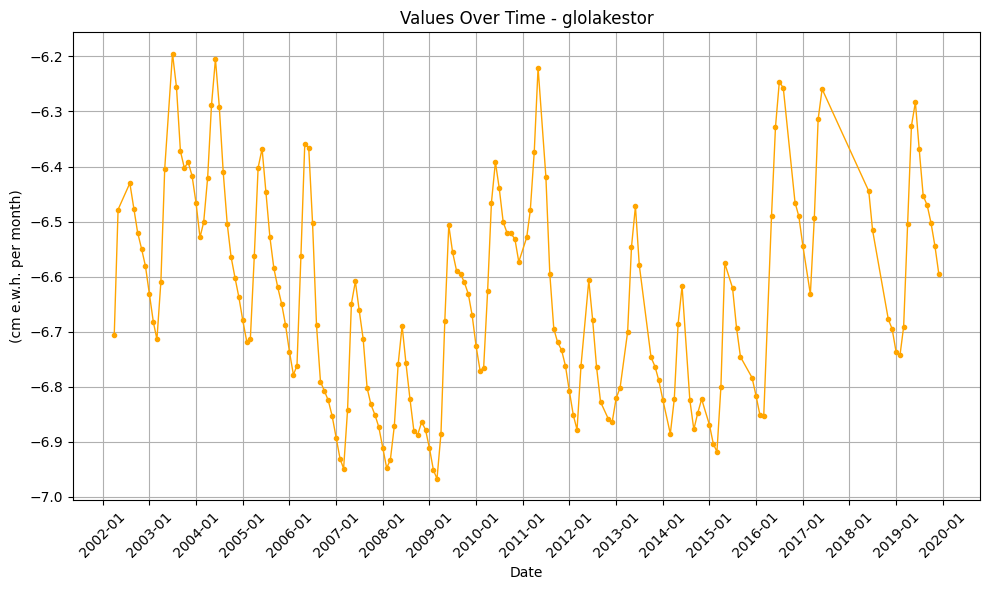

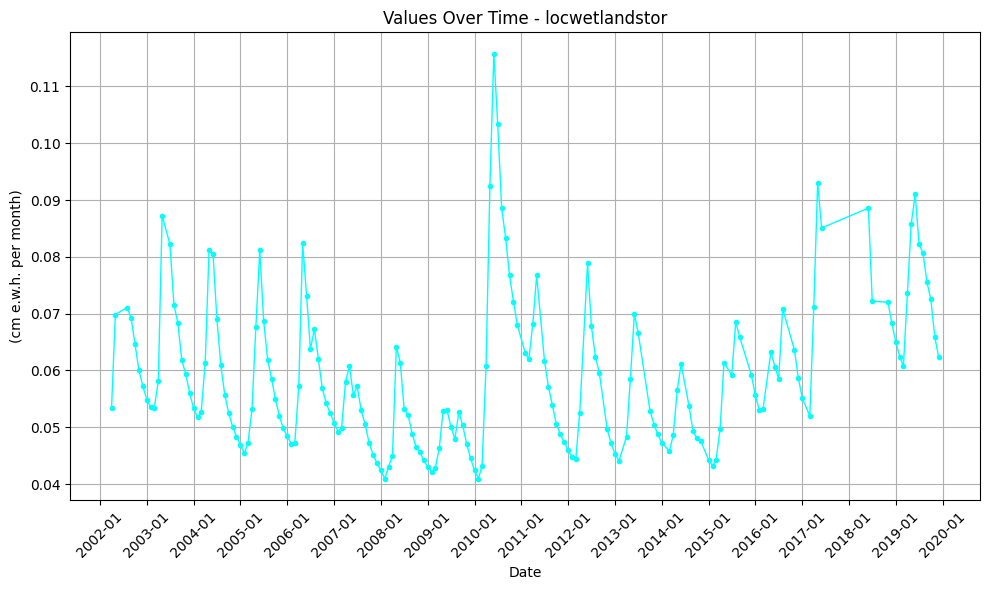

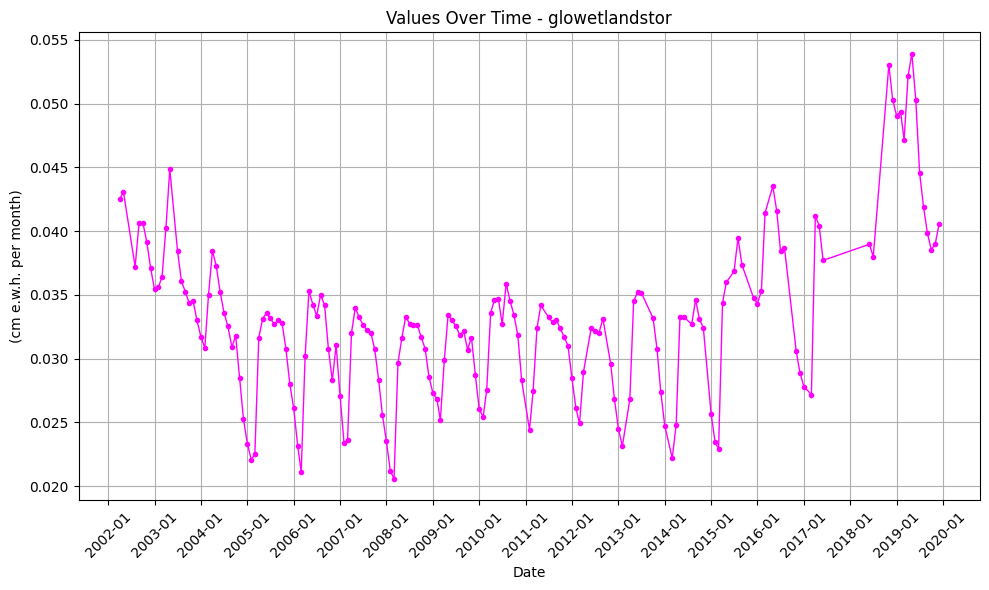

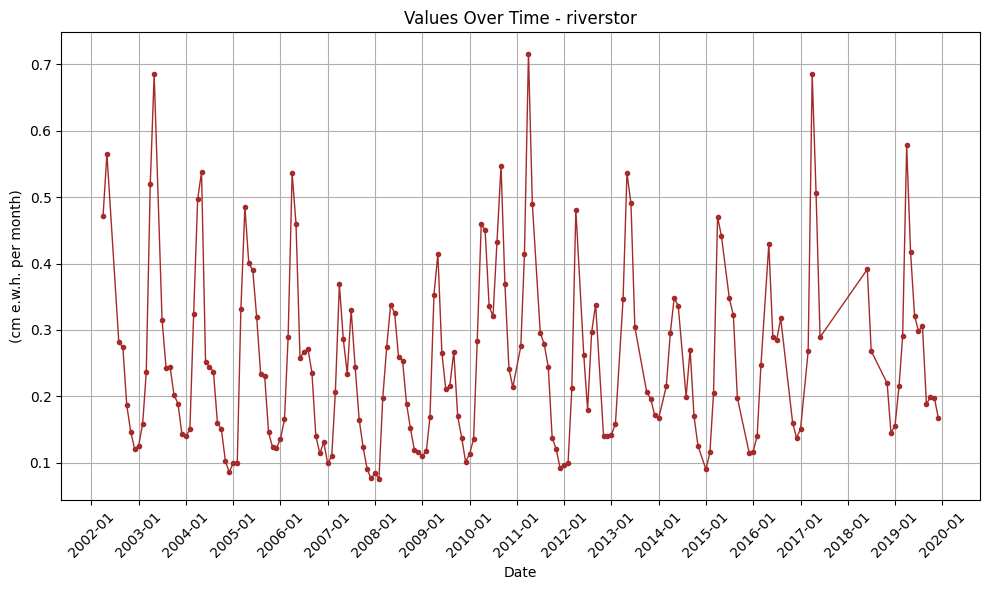

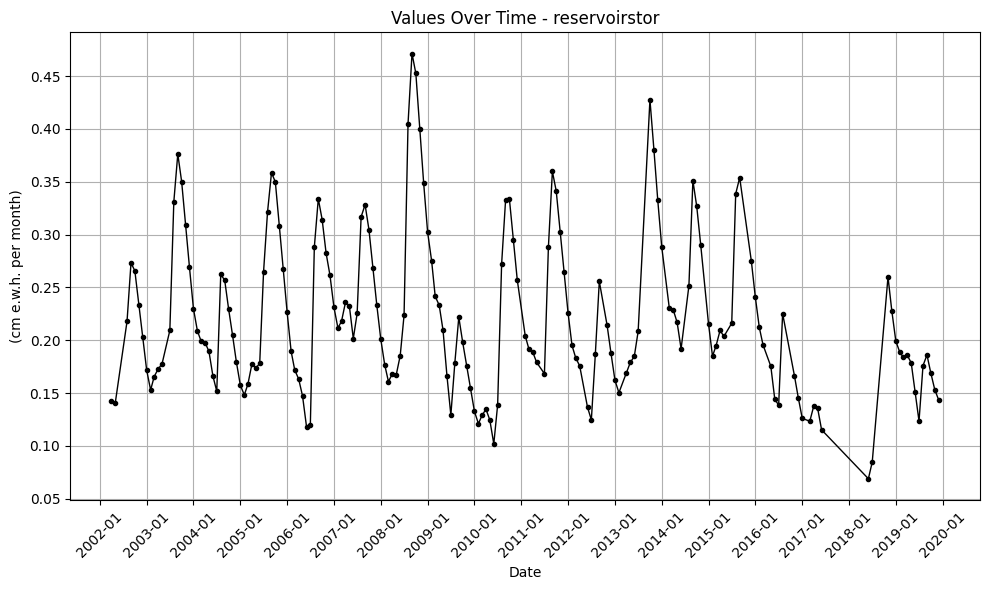

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


def convert_flux_to_monthly_height(arg_values):
    seconds_per_month = 30 * 86400
    return [(arg * seconds_per_month) / 10 for arg in arg_values]

def convert_from_mm_to_cm(arg_values):
    return [(arg) / 10 for arg in arg_values] # for cm / month


data_list = [tws, sm, snow_water, cp , lls , gls , lwls , gwls , ris , res];



subtracted_arg = [tws_value - summation for tws_value, summation in zip(tws['ARG'], summation_arg)]





print(tws['ARG']);



titles = ['TWS', 'Soil moisture', 'Snow water', 'Canopy stor' , 'loclakestor' , 'glolakestor' , 'locwetlandstor' , 'glowetlandstor' , 'riverstor' , 'reservoirstor' ]
colors = ['b','b', 'g', 'r', 'purple', 'orange', 'cyan', 'magenta', 'brown', 'black']

for i, (data, title, color) in enumerate(zip(data_list, titles, colors)):
    dates = data['Date']

    converted_arg = convert_from_mm_to_cm(data['ARG'])

    plt.figure(figsize=(10, 6))
    plt.plot(dates, converted_arg, marker='o', linestyle='-', linewidth=1, markersize=3, color=color)


    plt.xlabel('Date')
    plt.ylabel('(cm e.w.h. per month)')
    plt.title(f'Values Over Time - {title}')


    plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Show major ticks every year
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as YYYY-MM


    plt.xticks(rotation=45)


    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
tws_old.sel(lat= aquifer_coords, lon=aquifer_coords[j][1])

<bound method Mapping.values of <xarray.Dataset> Size: 1GB
Dimensions:  (lat: 360, lon: 720, time: 1428)
Coordinates:
  * lat      (lat) float32 1kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 3kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * time     (time) datetime64[ns] 11kB 1901-01-01 1901-02-01 ... 2019-12-01
Data variables:
    tws      (time, lat, lon) float32 1GB ...
Attributes:
    title:          Standard model output for Water - Global Assessment and P...
    institution:    Institute for Physical Geography (IPG), Goethe University...
    project:        Model description paper WaterGAP v2.2e
    model_version:  watergap22e
    reference:      Müller Schmied et al. (in prep. for the journal Geoscient...
    forcing:        gswp3-w5e5
    conventions:    partly ISIMIP3 protocol for naming and units
    contact:        hydrology@em.uni-frankfurt.de
    licence:        CC BY 4.0
    history:        created 2023-09-30>

In [ ]:
tws_old.lat.values

array([ 89.75,  89.25,  88.75,  88.25,  87.75,  87.25,  86.75,  86.25,
        85.75,  85.25,  84.75,  84.25,  83.75,  83.25,  82.75,  82.25,
        81.75,  81.25,  80.75,  80.25,  79.75,  79.25,  78.75,  78.25,
        77.75,  77.25,  76.75,  76.25,  75.75,  75.25,  74.75,  74.25,
        73.75,  73.25,  72.75,  72.25,  71.75,  71.25,  70.75,  70.25,
        69.75,  69.25,  68.75,  68.25,  67.75,  67.25,  66.75,  66.25,
        65.75,  65.25,  64.75,  64.25,  63.75,  63.25,  62.75,  62.25,
        61.75,  61.25,  60.75,  60.25,  59.75,  59.25,  58.75,  58.25,
        57.75,  57.25,  56.75,  56.25,  55.75,  55.25,  54.75,  54.25,
        53.75,  53.25,  52.75,  52.25,  51.75,  51.25,  50.75,  50.25,
        49.75,  49.25,  48.75,  48.25,  47.75,  47.25,  46.75,  46.25,
        45.75,  45.25,  44.75,  44.25,  43.75,  43.25,  42.75,  42.25,
        41.75,  41.25,  40.75,  40.25,  39.75,  39.25,  38.75,  38.25,
        37.75,  37.25,  36.75,  36.25,  35.75,  35.25,  34.75,  34.25,
      

In [ ]:
tws_old.lon.values

array([-179.75, -179.25, -178.75, -178.25, -177.75, -177.25, -176.75,
       -176.25, -175.75, -175.25, -174.75, -174.25, -173.75, -173.25,
       -172.75, -172.25, -171.75, -171.25, -170.75, -170.25, -169.75,
       -169.25, -168.75, -168.25, -167.75, -167.25, -166.75, -166.25,
       -165.75, -165.25, -164.75, -164.25, -163.75, -163.25, -162.75,
       -162.25, -161.75, -161.25, -160.75, -160.25, -159.75, -159.25,
       -158.75, -158.25, -157.75, -157.25, -156.75, -156.25, -155.75,
       -155.25, -154.75, -154.25, -153.75, -153.25, -152.75, -152.25,
       -151.75, -151.25, -150.75, -150.25, -149.75, -149.25, -148.75,
       -148.25, -147.75, -147.25, -146.75, -146.25, -145.75, -145.25,
       -144.75, -144.25, -143.75, -143.25, -142.75, -142.25, -141.75,
       -141.25, -140.75, -140.25, -139.75, -139.25, -138.75, -138.25,
       -137.75, -137.25, -136.75, -136.25, -135.75, -135.25, -134.75,
       -134.25, -133.75, -133.25, -132.75, -132.25, -131.75, -131.25,
       -130.75, -130

In [ ]:
lwe_thickness.lat.values

array([-89.75, -89.25, -88.75, -88.25, -87.75, -87.25, -86.75, -86.25,
       -85.75, -85.25, -84.75, -84.25, -83.75, -83.25, -82.75, -82.25,
       -81.75, -81.25, -80.75, -80.25, -79.75, -79.25, -78.75, -78.25,
       -77.75, -77.25, -76.75, -76.25, -75.75, -75.25, -74.75, -74.25,
       -73.75, -73.25, -72.75, -72.25, -71.75, -71.25, -70.75, -70.25,
       -69.75, -69.25, -68.75, -68.25, -67.75, -67.25, -66.75, -66.25,
       -65.75, -65.25, -64.75, -64.25, -63.75, -63.25, -62.75, -62.25,
       -61.75, -61.25, -60.75, -60.25, -59.75, -59.25, -58.75, -58.25,
       -57.75, -57.25, -56.75, -56.25, -55.75, -55.25, -54.75, -54.25,
       -53.75, -53.25, -52.75, -52.25, -51.75, -51.25, -50.75, -50.25,
       -49.75, -49.25, -48.75, -48.25, -47.75, -47.25, -46.75, -46.25,
       -45.75, -45.25, -44.75, -44.25, -43.75, -43.25, -42.75, -42.25,
       -41.75, -41.25, -40.75, -40.25, -39.75, -39.25, -38.75, -38.25,
       -37.75, -37.25, -36.75, -36.25, -35.75, -35.25, -34.75, -34.25,
      

In [ ]:
lwe_thickness.lon.values

array([2.5000e-01, 7.5000e-01, 1.2500e+00, 1.7500e+00, 2.2500e+00,
       2.7500e+00, 3.2500e+00, 3.7500e+00, 4.2500e+00, 4.7500e+00,
       5.2500e+00, 5.7500e+00, 6.2500e+00, 6.7500e+00, 7.2500e+00,
       7.7500e+00, 8.2500e+00, 8.7500e+00, 9.2500e+00, 9.7500e+00,
       1.0250e+01, 1.0750e+01, 1.1250e+01, 1.1750e+01, 1.2250e+01,
       1.2750e+01, 1.3250e+01, 1.3750e+01, 1.4250e+01, 1.4750e+01,
       1.5250e+01, 1.5750e+01, 1.6250e+01, 1.6750e+01, 1.7250e+01,
       1.7750e+01, 1.8250e+01, 1.8750e+01, 1.9250e+01, 1.9750e+01,
       2.0250e+01, 2.0750e+01, 2.1250e+01, 2.1750e+01, 2.2250e+01,
       2.2750e+01, 2.3250e+01, 2.3750e+01, 2.4250e+01, 2.4750e+01,
       2.5250e+01, 2.5750e+01, 2.6250e+01, 2.6750e+01, 2.7250e+01,
       2.7750e+01, 2.8250e+01, 2.8750e+01, 2.9250e+01, 2.9750e+01,
       3.0250e+01, 3.0750e+01, 3.1250e+01, 3.1750e+01, 3.2250e+01,
       3.2750e+01, 3.3250e+01, 3.3750e+01, 3.4250e+01, 3.4750e+01,
       3.5250e+01, 3.5750e+01, 3.6250e+01, 3.6750e+01, 3.7250e

In [ ]:
tws_old.sel(lat = 0.75 , lon = 179.75)['tws'].values[0]

nan

In [ ]:
"""
if gdf.geometry.geom_type[0] == 'Polygon':

    coords = [list(geom.exterior.coords) for geom in gdf.geometry]

elif gdf.geometry.geom_type[0] == 'LineString':

    coords = [list(geom.coords) for geom in gdf.geometry]

coords_array = np.array(coords, dtype=object)



for row in coords_aquifer:
    row[0] += 360

coords_aquifer


min_value = min(row[0] for row in coords_aquifer)
max_value = max(row[0] for row in coords_aquifer)




'
coords_aquifer = [];
for i in range(0,len(coords)):
    coords_aquifer.append([ round((coords[i][0] + 0.25) * 2) / 2 - 0.25 , round((coords[i][1] + 0.25) * 2) / 2 - 0.25 ])

'



'

print(max(grace_subset_north.lon.values) - 360)
print(min(grace_subset_north.lon.values) - 360)
print(max(grace_subset_north.lat.values))
print(min(grace_subset_north.lat.values))


'


'



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import Normalize
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_trend_map2(lat_min, lat_max, lon_min, lon_max, lat_array, lon_array, trend_array, aquifer_boundary):
    """
    Generates a trend map with rectangular grids, aquifer boundary, state boundaries,
    and color intensity proportional to the trend magnitude (in cm/year).
    """

    # Convert trend from cm/day to cm/year
    trend_array = np.array(trend_array) * 365  # Conversion factor

    # Get the min and max trend values for color normalization
    vmin, vmax = trend_array.min(), trend_array.max()
    # Set up the plot with PlateCarree projection and smaller size
    fig, ax = plt.subplots(
        figsize=(8, 10),  # Adjusted figure size for a smaller image
        subplot_kw={'projection': ccrs.PlateCarree()}
    )

    # Add state boundaries and coastlines
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle='--', edgecolor='gray')

    # Plot the Ogallala Aquifer boundary
    aquifer_boundary.plot(ax=ax, edgecolor='black', linewidth=1.5, facecolor='none')

    # Set up the color map: red for loss, blue for gain
    cmap = plt.get_cmap('RdBu_r')  # Reversed RdBu colormap
    norm = Normalize(vmin=vmin, vmax=vmax)  # Dynamically normalize based on trend values

    # Plot each grid cell with the appropriate color
    for lat, lon, trend in zip(lat_array, lon_array, trend_array):
        color = cmap(norm(trend))  # Get color based on trend value
        rect = plt.Rectangle(
            (lon - 0.25, lat - 0.25),  # Bottom-left corner
            0.5, 0.5,                  # Width and height of each cell
            edgecolor='black', facecolor=color, alpha=0.7,
            transform=ccrs.PlateCarree()
        )
        ax.add_patch(rect)

    # Add a color bar to indicate the trend values
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
    cbar.set_label('Trend (cm/year)', fontsize=10)
    cbar.ax.tick_params(labelsize=8)

    # Set the extent to focus on the Ogallala region
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # Add state labels
    state_labels = {'CO': (-105.5, 39), 'KS': (-98, 38), 'OK': (-98, 35),
                    'TX': (-102, 33), 'NM': (-104, 34), 'NE': (-99, 41),
                    'SD': (-100, 44), 'WY': (-107, 43)}
    for state, (x, y) in state_labels.items():
        ax.text(x, y, state, transform=ccrs.PlateCarree(), fontsize=10, ha='center')

    # Add a dashed line to divide northern and southern regions
    ax.plot([-106, -96], [38, 38], linestyle='--', color='black', transform=ccrs.PlateCarree())

    # Add labels for the regions
    ax.text(-97, 39.5, 'NORTH', fontsize=12, weight='bold', ha='center', transform=ccrs.PlateCarree())
    ax.text(-97, 36.5, 'SOUTH', fontsize=12, weight='bold', ha='center', transform=ccrs.PlateCarree())

    # Show the plot
    plt.show()

'


"""



In [ ]:
tws

{'Date': array([datetime.date(2002, 4, 1), datetime.date(2002, 5, 1),
        datetime.date(2002, 8, 1), datetime.date(2002, 9, 1),
        datetime.date(2002, 10, 1), datetime.date(2002, 11, 1),
        datetime.date(2002, 12, 1), datetime.date(2003, 1, 1),
        datetime.date(2003, 2, 1), datetime.date(2003, 3, 1),
        datetime.date(2003, 4, 1), datetime.date(2003, 5, 1),
        datetime.date(2003, 7, 1), datetime.date(2003, 8, 1),
        datetime.date(2003, 9, 1), datetime.date(2003, 10, 1),
        datetime.date(2003, 11, 1), datetime.date(2003, 12, 1),
        datetime.date(2004, 1, 1), datetime.date(2004, 2, 1),
        datetime.date(2004, 3, 1), datetime.date(2004, 4, 1),
        datetime.date(2004, 5, 1), datetime.date(2004, 6, 1),
        datetime.date(2004, 7, 1), datetime.date(2004, 8, 1),
        datetime.date(2004, 9, 1), datetime.date(2004, 10, 1),
        datetime.date(2004, 11, 1), datetime.date(2004, 12, 1),
        datetime.date(2005, 1, 1), datetime.date(2005

In [ ]:
max(amp2)

2160.430157716957

In [ ]:
aquifer_coords

[[41.25, 254.75],
 [41.75, 254.75],
 [42.25, 254.75],
 [40.75, 255.25],
 [41.25, 255.25],
 [41.75, 255.25],
 [42.25, 255.25],
 [42.75, 255.25],
 [40.75, 255.75],
 [41.25, 255.75],
 [41.75, 255.75],
 [42.25, 255.75],
 [42.75, 255.75],
 [32.75, 256.25],
 [33.25, 256.25],
 [33.75, 256.25],
 [34.25, 256.25],
 [36.25, 256.25],
 [40.75, 256.25],
 [41.25, 256.25],
 [41.75, 256.25],
 [42.25, 256.25],
 [32.75, 256.75],
 [33.25, 256.75],
 [33.75, 256.75],
 [34.25, 256.75],
 [35.75, 256.75],
 [36.25, 256.75],
 [39.25, 256.75],
 [39.75, 256.75],
 [40.75, 256.75],
 [41.25, 256.75],
 [41.75, 256.75],
 [42.25, 256.75],
 [32.25, 257.25],
 [32.75, 257.25],
 [33.25, 257.25],
 [33.75, 257.25],
 [34.25, 257.25],
 [34.75, 257.25],
 [35.75, 257.25],
 [36.25, 257.25],
 [36.75, 257.25],
 [37.25, 257.25],
 [38.75, 257.25],
 [39.25, 257.25],
 [39.75, 257.25],
 [40.25, 257.25],
 [40.75, 257.25],
 [41.25, 257.25],
 [41.75, 257.25],
 [42.25, 257.25],
 [31.75, 257.75],
 [32.25, 257.75],
 [32.75, 257.75],
 [33.25, 2

In [ ]:
coords

[(-105.17127815341775, 41.493415186461974),
 (-105.17127815341775, 41.993415186461974),
 (-105.17127815341775, 42.493415186461974),
 (-104.67127815341775, 40.993415186461974),
 (-104.67127815341775, 41.493415186461974),
 (-104.67127815341775, 41.993415186461974),
 (-104.67127815341775, 42.493415186461974),
 (-104.67127815341775, 42.993415186461974),
 (-104.17127815341775, 40.993415186461974),
 (-104.17127815341775, 41.493415186461974),
 (-104.17127815341775, 41.993415186461974),
 (-104.17127815341775, 42.493415186461974),
 (-104.17127815341775, 42.993415186461974),
 (-103.67127815341775, 32.993415186461974),
 (-103.67127815341775, 33.493415186461974),
 (-103.67127815341775, 33.993415186461974),
 (-103.67127815341775, 34.493415186461974),
 (-103.67127815341775, 36.493415186461974),
 (-103.67127815341775, 40.993415186461974),
 (-103.67127815341775, 41.493415186461974),
 (-103.67127815341775, 41.993415186461974),
 (-103.67127815341775, 42.493415186461974),
 (-103.17127815341775, 32.993415